In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import regionmask
import xesmf

import sys
sys.path.append('../')
import utils
import plotting


#### Approach

1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

# Import Data

In [2]:
models = ['normal_model','nonuc_model','no_coal','nonuc_renewables_model']
pollutants = ['NO','NO2','SO2','CO2','CH4']

regionname_grouped_ds = xr.open_zarr(f'./final_data/regionname_grouped_emissions_ds.zarr')
fueltype_grouped_ds = xr.open_zarr(f'./final_data/fueltype_grouped_emissions_ds.zarr')
gmodel_egrid_ds = xr.open_zarr(f'./final_data/gmodel_egrid_emissions_ds.zarr')
oris_nonuc_ds = xr.open_zarr(f'./final_data/oris_nonuc_ds.zarr')

In [3]:
region_season = utils.season_mean(regionname_grouped_ds.rename({'date':'time'}))
fuel_season = utils.season_mean(fueltype_grouped_ds.rename({'date':'time'}))


In [4]:
convert_NO_N = 14.01/30.01
convert_NO2_N = 14.01/46.01
gmodel_egrid_ds['model_annual_NOx_conc'] = (gmodel_egrid_ds['model_annual_NO_conc']*convert_NO_N+
                                               gmodel_egrid_ds['model_annual_NO2_conc']*convert_NO2_N)

In [5]:
EIA_proj = pd.read_excel('../optimization_model/good_model_inputs/2030_proj_EIA.xlsx', sheet_name = 'EIA_proj')
EIA_regs = pd.read_excel('../optimization_model/good_model_inputs/2030_proj_EIA.xlsx', sheet_name = 'EIA_egrid_regions')

print('Data Info')
print(EIA_proj.iloc[-2])
print(EIA_proj.iloc[-1])

EIA_proj = EIA_proj.dropna()
EIA_all = EIA_proj.rename(columns = {'Region':'EIA_reg'}).merge(EIA_regs)

Data Info
Region        Regions named via: https://www.eia.gov/outlook...
2030 solar                                                  NaN
2030 wind                                                   NaN
Name: 29, dtype: object
Region        Data attained at: table 56: https://www.eia.go...
2030 solar                                                  NaN
2030 wind                                                   NaN
Name: 30, dtype: object


# Check EIA Data vs. Solar and Wind Optimization Estimates

In [6]:
df_model_wind = (gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'wind_generator', drop = True)['annual_modelgeneration'].groupby('regionname').sum()+
    gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'Wind', drop = True)['annual_modelgeneration'].sel(
        model_name = 'nonuc_renewables_model').groupby('regionname').sum()).to_dataframe()
df_model_solar = (gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'solar_generator', drop = True)['annual_modelgeneration'].groupby('regionname').sum()+
    gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'Solar', drop = True)['annual_modelgeneration'].sel(
        model_name = 'nonuc_renewables_model').groupby('regionname').sum()).to_dataframe()

In [7]:
df_model_wind = df_model_wind.reset_index().rename(columns = {'index':'egrid_reg', 'annual_modelgeneration':'wind_gen_model'})
df_model_solar = df_model_solar.reset_index().rename(columns = {'index':'egrid_reg', 'annual_modelgeneration':'solar_gen_model'})

In [8]:
comp_df = EIA_all.merge(df_model_solar).merge(df_model_wind)

In [9]:
mwh_per_gw_per_year = 1/(1000*8760)

#### Should be greater than zero to ensure we aren't using more capacity than would be available:

Text(0.5, 0, 'Region')

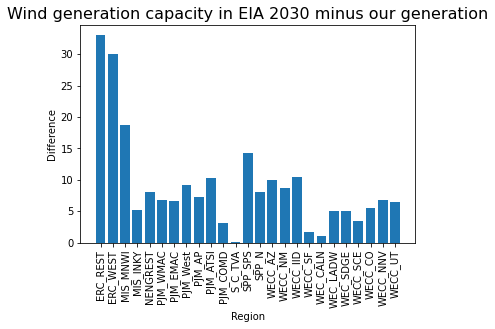

In [10]:
plt.bar(comp_df['egrid_reg'], comp_df['2030 wind']-comp_df['wind_gen_model']*mwh_per_gw_per_year)
plt.xticks(rotation = 90);
plt.title('Wind generation capacity in EIA 2030 minus our generation', fontsize = 16)
plt.ylabel('Difference')
plt.xlabel('Region')

Text(0.5, 0, 'Region')

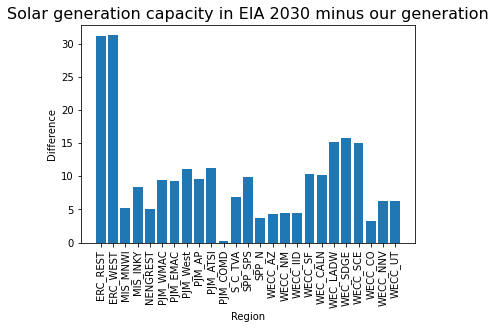

In [11]:
plt.bar(comp_df['egrid_reg'], comp_df['2030 solar']-comp_df['solar_gen_model']*mwh_per_gw_per_year)
plt.xticks(rotation = 90);
plt.title('Solar generation capacity in EIA 2030 minus our generation', fontsize = 16)
plt.ylabel('Difference')
plt.xlabel('Region')

# Plot settings

In [12]:
###set color for each type
nonuc_color = 'C1'
normal_color = 'C0'
egrid_color = 'C7'
nocoal_color = 'c'
renewables_color = 'C3'

### set scientific names
sci_names = {'NO':r'$NO$', 'SO2':r'$SO_2$', 'NO2':r'$NO_2$', 'CO2':r'$CO_2$', 'CH4':r'$CH_4$' }

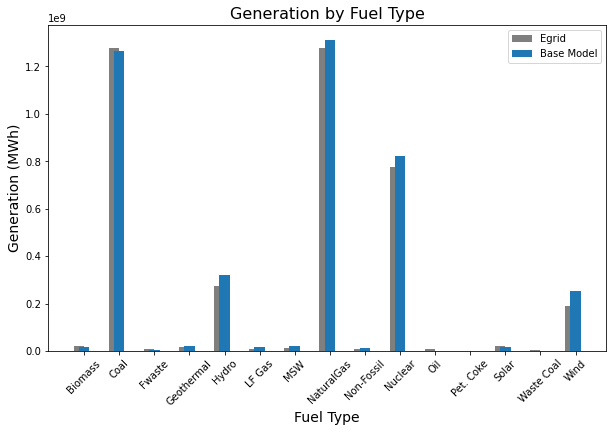

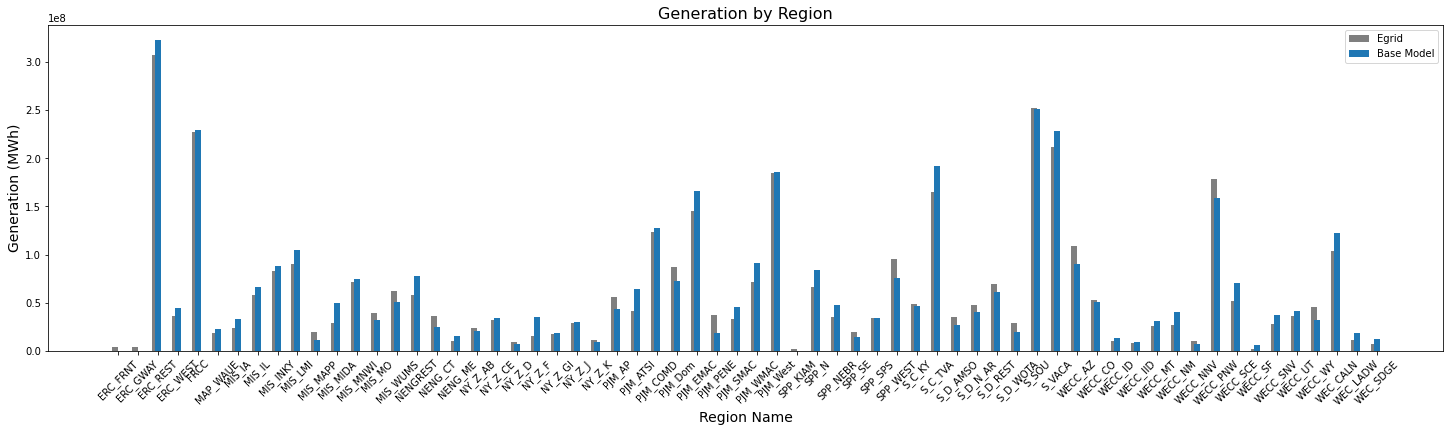

In [13]:
### plot all three egrid, nonuc, normal model generation by:

#fuel type
plotting.plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype',
                           yvariable1 = 'annual_modelgeneration',egrid = True, noxlim = False,
                           egrid_yvariable = 'annual_egridgeneration', figsize = [10,6], nocoal = False, renew = False, nonuc = False)
plt.xlabel('Fuel Type', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Fuel Type', fontsize = 16);
plt.savefig('./Figures/fuel_type_base_egrid.png', dpi=300, bbox_inches = 'tight')

#region name
plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True,  noxlim = False,
                           yvariable1 = 'annual_modelgeneration', egrid_yvariable = 'annual_egridgeneration', 
                           figsize = [25,6], nocoal = False, renew = False, nonuc = False)
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Generation by Region', fontsize = 16);
plt.savefig('./Figures/region_name_base_egrid.png', dpi=300, bbox_inches = 'tight')


## Percent change in generation

In [14]:
fuel = 'Coal'

In [15]:
((fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'nonuc_model')-
  fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model'))/
 fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model')).values*100

43.67945030487485

In [16]:
((fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'nonuc_nocoal_model')-
  fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model'))/
 fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model')).values*100

nan

In [17]:
((fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'nonuc_renewables_model')-
  fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model'))/
 fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = 'normal_model')).values*100

8.65446027757079

## Percent of generation by source in each scenario

In [18]:
fuel = 'solar_generator'
model = 'nonuc_renewables_model'

In [19]:
((fueltype_grouped_ds['annual_modelgeneration'].sel(fueltype = fuel).sel(model_name = model))/
 fueltype_grouped_ds['annual_modelgeneration'].sel(model_name = model).sum()).values*100

7.650702757067673

# Emissions Changes

##  By Region, Fuel Type

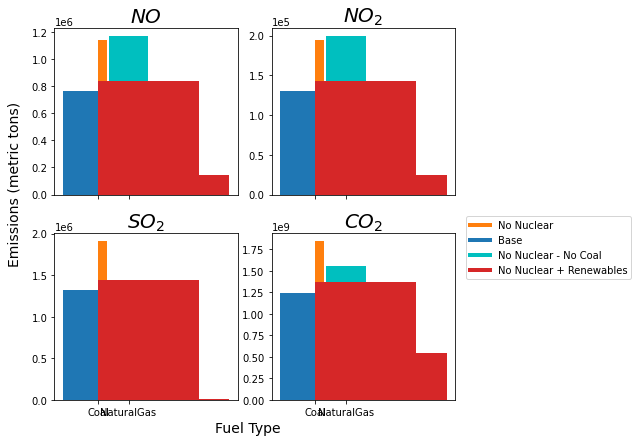

In [20]:
#plot by fuel type
plotting.fossil_fuel_plot(fueltype_grouped_ds, sci_names = sci_names, xvariable = 'fueltype', 
                          pollutants = ['NO','NO2','SO2','CO2'], figsize = [9,6], egrid = False,
                         nonuc_color = nonuc_color, normal_color = normal_color, egrid_color = egrid_color, noxlim = False, nocoal = True, renew = True)
#plt.savefig('./Figures/emissions_fueltype.png', bbox_inches = 'tight', dpi = 150)

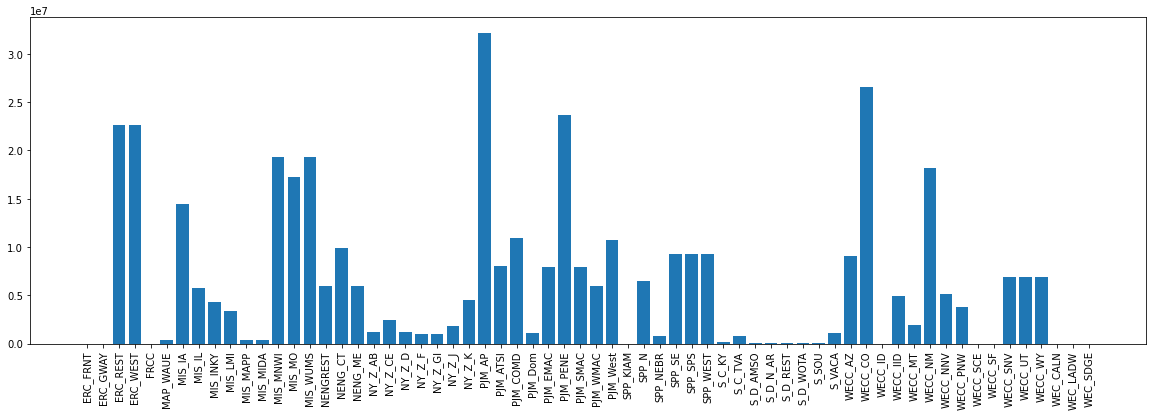

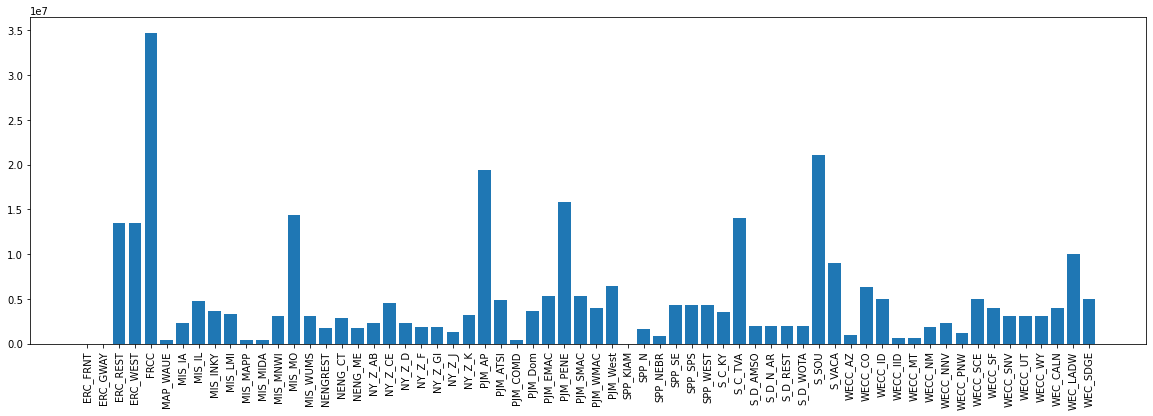

In [22]:
fig, ax = plt.subplots(figsize = (20,6))
plt.bar(gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'wind_generator', drop = True).sel(model_name = 'nonuc_renewables_model')['regionname'],
        gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'wind_generator', drop = True).sel(model_name = 'nonuc_renewables_model')['annual_modelgeneration'])
plt.xticks(rotation = 90);

fig, ax = plt.subplots(figsize = (20,6))
plt.bar(gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'solar_generator', drop = True).sel(model_name = 'nonuc_renewables_model')['regionname'],
        gmodel_egrid_ds.where(gmodel_egrid_ds.fueltype == 'solar_generator', drop = True).sel(model_name = 'nonuc_renewables_model')['annual_modelgeneration'])
plt.xticks(rotation = 90);

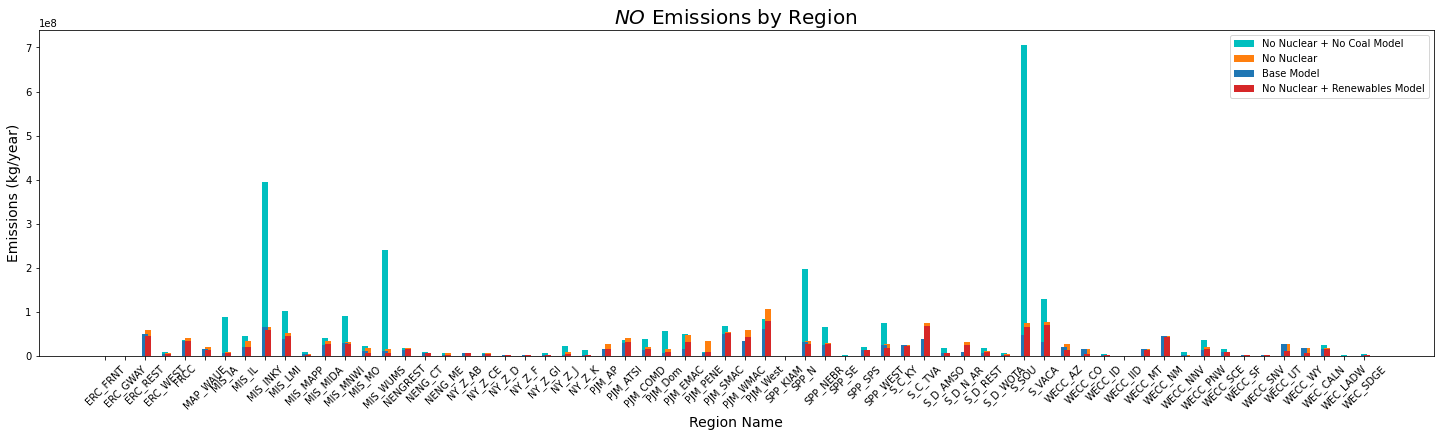

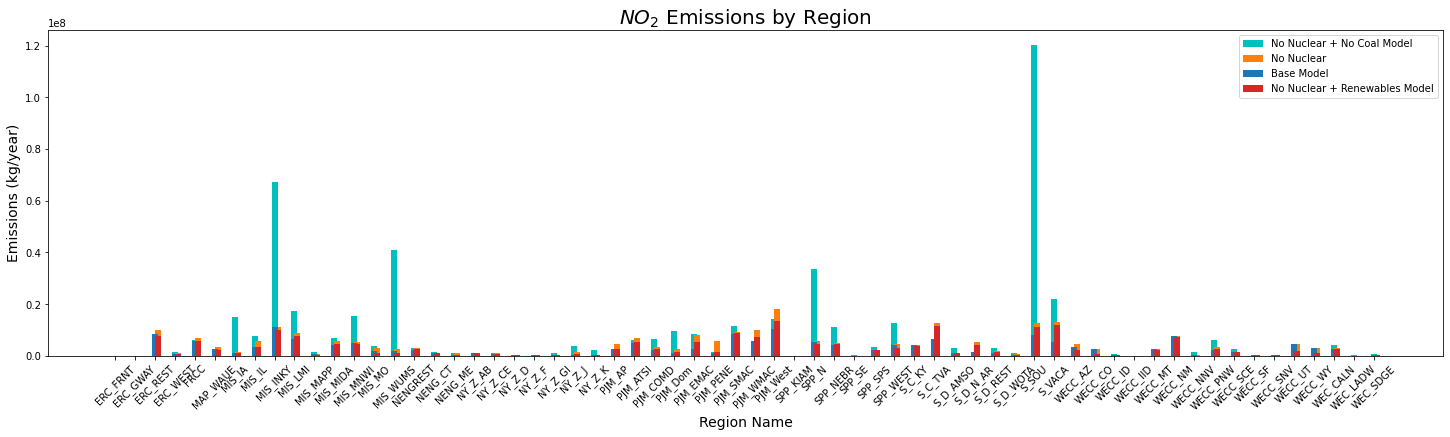

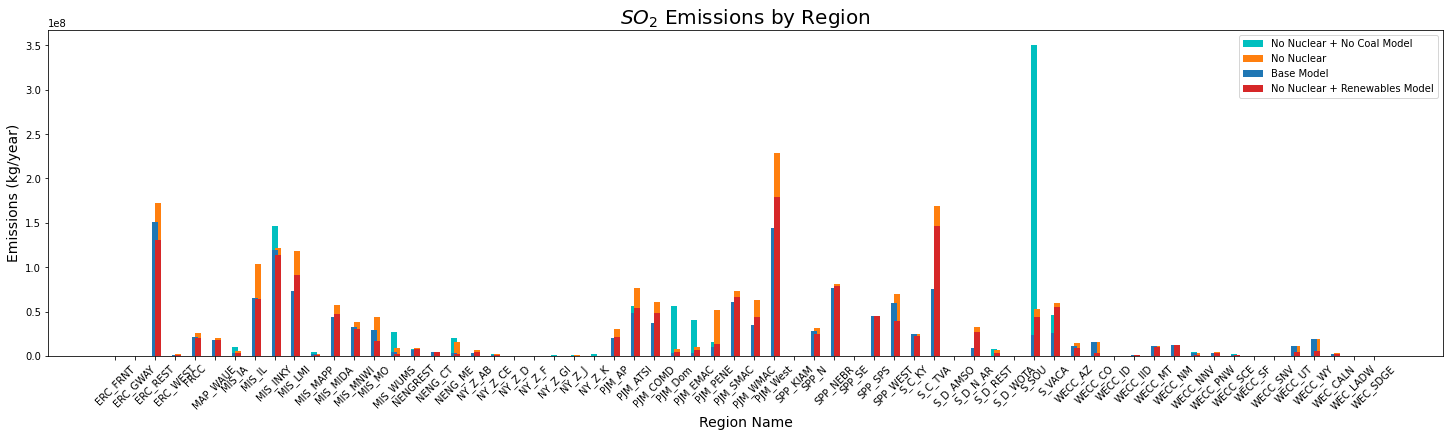

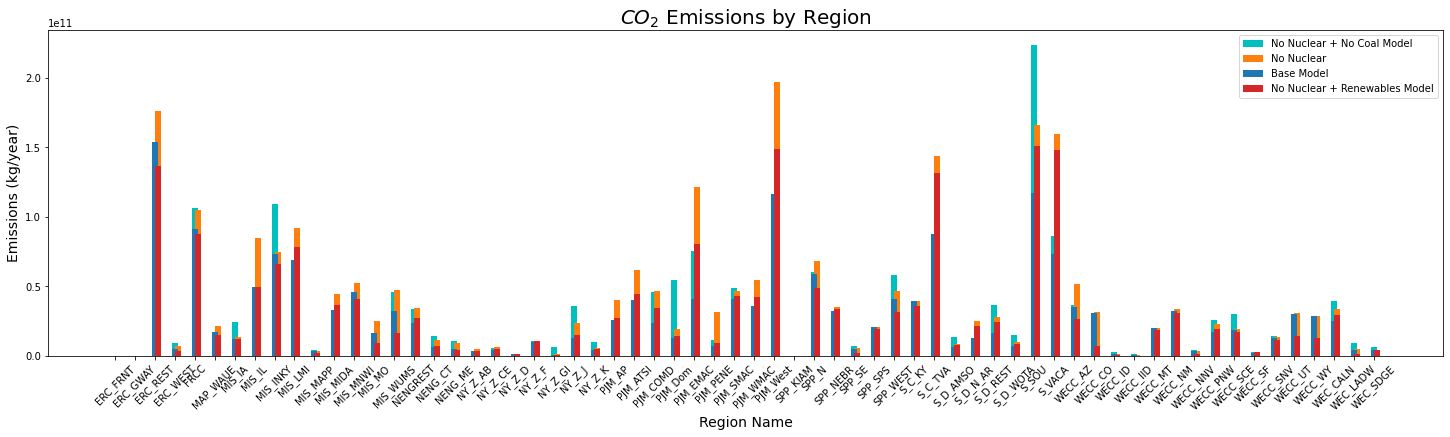

In [25]:
for pollutant in ['NO','NO2','SO2','CO2']:
    #plot by region
    plotting.plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',
                               egrid = False, yvariable1 = f'model_annual_{pollutant}_conc', 
                               egrid_yvariable = f'egrid_annual_{pollutant}_conc', figsize = [25,6], nocoal = True, renew = True, noxlim = False)
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'Emissions (kg/year)', fontsize = 14)
    plt.title(f'{sci_names[pollutant]} Emissions by Region', fontsize = 20);


## Percent Change in Emissions

In [26]:
### make a percent change variable in pollutants
for pollutant in pollutants:
    for m in ['nonuc_model','nonuc_nocoal_model']:
        fueltype_grouped_ds[f'{m}_{pollutant}_percent_change'] = 100* ((fueltype_grouped_ds.sel(model_name = m)[f'model_annual_{pollutant}_conc'] - 
                                     fueltype_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc'])/fueltype_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc'])

In [27]:
for m in ['nonuc_model','nonuc_nocoal_model']:
    print('\n', m, '\n')
    for pollutant in ['NO','NO2','SO2','CO2']:
        print(f'Coal {pollutant} increase ' +
              str(fueltype_grouped_ds.sel(model_name = m)[f'{m}_{pollutant}_percent_change'].sel(fueltype = 'Coal').values))
        print(f'Natural Gas {pollutant} increase ' +
              str(fueltype_grouped_ds.sel(model_name = m)[f'{m}_{pollutant}_percent_change'].sel(fueltype = 'NaturalGas').values))
        print(f'Oil {pollutant} increase ' +
              str(fueltype_grouped_ds.sel(model_name = m)[f'{m}_{pollutant}_percent_change'].sel(fueltype = 'Oil').values))


 nonuc_model 

Coal NO increase 49.65706818141903
Natural Gas NO increase 39.59229286610943
Oil NO increase 250.92761116861118
Coal NO2 increase 49.65706818141896
Natural Gas NO2 increase 39.59229286610946
Oil NO2 increase 250.92761116861112
Coal SO2 increase 44.693937228444895
Natural Gas SO2 increase 205.46152219771736
Oil SO2 increase 9.439120027429453
Coal CO2 increase 47.9224328922487
Natural Gas CO2 increase 24.94933197874304
Oil CO2 increase 3978.8994094525938

 nonuc_nocoal_model 

Coal NO increase -100.0
Natural Gas NO increase 762.8416319142653
Oil NO increase 29223751.638236888
Coal NO2 increase -100.0
Natural Gas NO2 increase 762.8416319142649
Oil NO2 increase 29223751.6382369
Coal SO2 increase -100.0


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Natural Gas SO2 increase 2696.343652885515
Oil SO2 increase 106747367.32334962
Coal CO2 increase -100.0
Natural Gas CO2 increase 195.93649708398488
Oil CO2 increase 98138794.48473437


## Total Changes

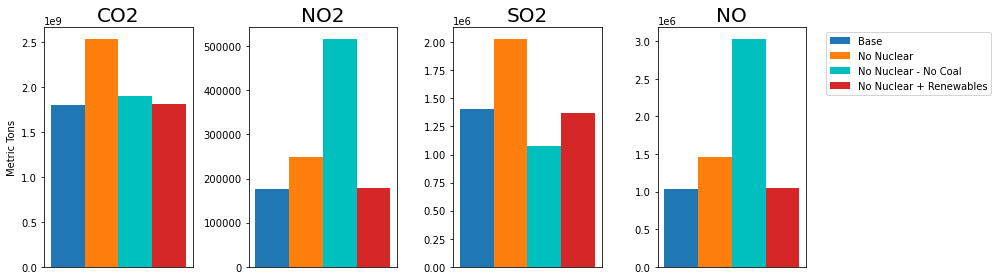

In [28]:
fig,axes = plt.subplots(1, 4, figsize=[14,4])
for idx_p, pollutant in enumerate(['CO2','NO2','SO2','NO']):
    ax = axes[idx_p]
    ax.bar(1.0, gmodel_egrid_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc'].sum().values/1000, 
           color = normal_color, width = .1, label = 'Base')
    ax.bar(1.05, gmodel_egrid_ds.sel(model_name = 'nonuc_model')[f'model_annual_{pollutant}_conc'].sum().values/1000, 
           color = nonuc_color, width = .1, align = 'edge', label = 'No Nuclear')
    ax.bar(1.15, gmodel_egrid_ds.sel(model_name = 'nonuc_nocoal_model')[f'model_annual_{pollutant}_conc'].sum().values/1000, 
           color = nocoal_color, width = .1, align = 'edge', label = 'No Nuclear - No Coal')
    ax.bar(1.25, gmodel_egrid_ds.sel(model_name = 'nonuc_renewables_model')[f'egrid_annual_{pollutant}_conc'].sum().values/1000, 
            color = renewables_color, width = .1, align = 'edge', label = 'No Nuclear + Renewables')
    ax.set_title(pollutant, fontsize = 20)
    ax.tick_params(axis = "x", which = "both", bottom = False, labelbottom = False)
axes[0].set_ylabel('Metric Tons')
plt.legend(bbox_to_anchor = [1.1, 1.0])
plt.tight_layout();


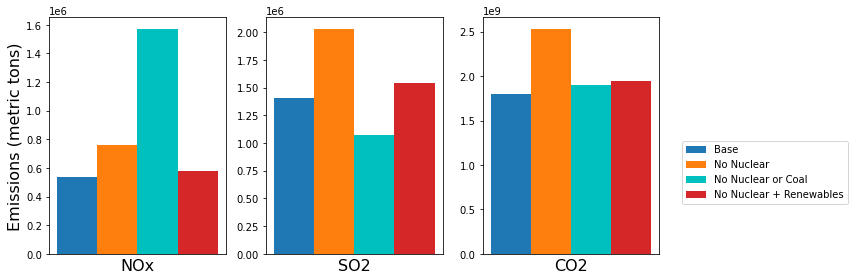

In [29]:
fig,axes = plt.subplots(1,3,  figsize = [12,4], sharex = True)
for ax, poll in zip(axes.flatten(),['NOx','SO2','CO2']):
    ax.bar(1.0,gmodel_egrid_ds[f'model_annual_{poll}_conc'].sel(model_name = 'normal_model').sum()/1000, 
           align = 'center', label = 'Base', color = normal_color, width = .1)
    ax.bar(1.05,gmodel_egrid_ds[f'model_annual_{poll}_conc'].sel(model_name = 'nonuc_model').sum()/1000, 
           align = 'edge',label = 'No Nuclear', color = nonuc_color, width = .1)
    ax.bar(1.2,gmodel_egrid_ds[f'model_annual_{poll}_conc'].sel(model_name = 'nonuc_nocoal_model').sum()/1000, 
           label = 'No Nuclear or Coal', color = nocoal_color, width = .1)
    ax.bar(1.25,gmodel_egrid_ds[f'model_annual_{poll}_conc'].sel(model_name = 'nonuc_renewables_model').sum()/1000, 
           align = 'edge', label = 'No Nuclear + Renewables', color = plotting.renew_color, width = .1)
#     ax.bar(1.4,gmodel_egrid_ds[f'model_annual_{poll}_conc'].sel(model_name = 'nox_lim_model').sum()/1000, 
#            align = 'edge', label = 'NOx Limited (No Nuclear/Coal)', color = plotting.nox_lim_color, width = .3)
    ax.set_xlabel(poll, fontsize = 16)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_xticks([])
    axes[0].set_ylabel('Emissions (metric tons)', fontsize = 16)
plt.legend(bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.tight_layout();
plt.savefig('Figures/emissions_models.pdf', bbox_inches = 'tight', dpi = 250)

In [30]:

for m in ['nonuc_model','nonuc_nocoal_model']:
    print('\n', m, '\n')
    for pollutant in ['NO','NO2','SO2','CO2']:
        print(f'{pollutant} percent increase overall ' + str((gmodel_egrid_ds.sel(
            model_name = m)[f'model_annual_{pollutant}_conc'].sum().values/1000- gmodel_egrid_ds.sel(
            model_name = 'normal_model')[f'model_annual_{pollutant}_conc'].sum().values/1000)/(gmodel_egrid_ds.sel(
            model_name = 'normal_model')[f'model_annual_{pollutant}_conc'].sum().values/1000)*100))
        print('normal value ' + str(gmodel_egrid_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc'].sum().values/1000) + ' tons')
        print(f'{m} value ' + str(gmodel_egrid_ds.sel(model_name = m)[f'model_annual_{pollutant}_conc'].sum().values/1000) + ' tons') 
        print(' ')


 nonuc_model 

NO percent increase overall 42.117536944110185
normal value 1031750.6848285729 tons
nonuc_model value 1466298.660682357 tons
 
NO2 percent increase overall 42.117536944110185
normal value 175779.7176811843 tons
nonuc_model value 249813.80521580967 tons
 
SO2 percent increase overall 44.477774256852726
normal value 1405917.4650766207 tons
nonuc_model value 2031238.2614310663 tons
 
CO2 percent increase overall 40.64189333086419
normal value 1801797996.6773338 tons
nonuc_model value 2534082816.524584 tons
 

 nonuc_nocoal_model 

NO percent increase overall 193.87570940800077
normal value 1031750.6848285729 tons
nonuc_nocoal_model value 3032064.644361875 tons
 
NO2 percent increase overall 193.8757094080008
normal value 175779.7176811843 tons
nonuc_nocoal_model value 516573.89233096136 tons
 
SO2 percent increase overall -23.631805316819
normal value 1405917.4650766207 tons
nonuc_nocoal_model value 1073673.786814557 tons
 
CO2 percent increase overall 5.4715783806843135
n

# Seasonal Emissions

In [31]:
emis_season = utils.season_mean(gmodel_egrid_ds[['model_NO_rate', 'model_NO2_rate', 'model_SO2_rate', 'model_CO2_rate']].rename({'date':'time'}))

In [32]:
for poll in ['NO','NO2','SO2','CO2']:
    print(poll, 'winter', 'summer')
    print((emis_season.sel(model_name = 'nonuc_model')-emis_season.sel(model_name = 'normal_model')).sel(season = 'DJF')[f'model_{poll}_rate'].sum().values*60*60*24*(28+31+30))
    print((emis_season.sel(model_name = 'nonuc_model')-emis_season.sel(model_name = 'normal_model')).sel(season = 'JJA')[f'model_{poll}_rate'].sum().values*60*60*24*(30+31+30))

NO winter summer
107570874.6089299
115514643.6476441
NO2 winter summer
18326886.76394481
19680269.416830294
SO2 winter summer
152667262.31934723
166036069.70781446
CO2 winter summer
181740243255.15405
181746393161.16147


## Plot by Fuel Type

DJF
JJA


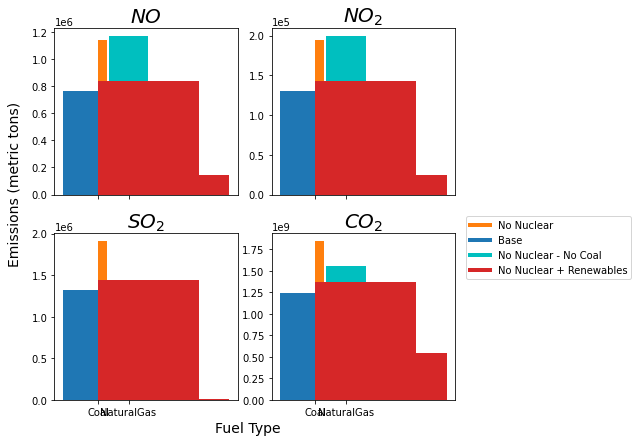

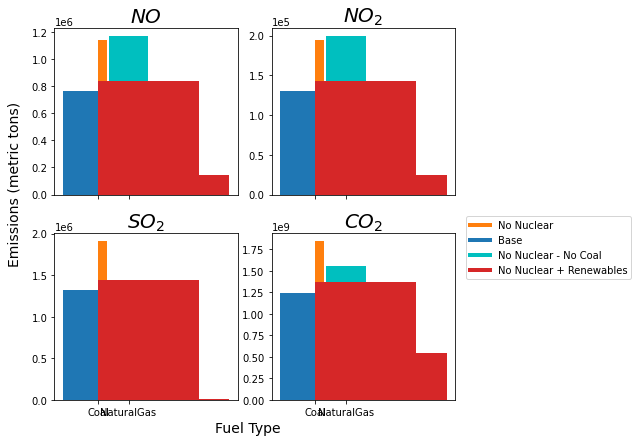

In [34]:
#plot by fuel type
print('DJF')
plotting.fossil_fuel_plot(fuel_season.sel(season = 'DJF'), sci_names = sci_names, xvariable = 'fueltype', 
                          pollutants = ['NO','NO2','SO2','CO2'], figsize = [9,6], egrid = False,
                         nonuc_color = nonuc_color, normal_color = normal_color, egrid_color = egrid_color, nocoal = True)
#plt.savefig('./Figures/emissions_fueltype.png', bbox_inches = 'tight', dpi = 150)

#plot by fuel type
print('JJA')
plotting.fossil_fuel_plot(fuel_season.sel(season = 'JJA'), sci_names = sci_names, xvariable = 'fueltype', 
                          pollutants = ['NO','NO2','SO2','CO2'], figsize = [9,6], egrid = False,
                         nonuc_color = nonuc_color, normal_color = normal_color, egrid_color = egrid_color, nocoal = True)
#plt.savefig('./Figures/emissions_fueltype.png', bbox_inches = 'tight', dpi = 150)